<a href="https://colab.research.google.com/github/geedoubledee/data620_project1/blob/main/DATA620_Project1_GDavis_BDavidoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Project 1
#### by Glen Davis and Brett Davidoff

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

## Introduction

We load anonymized node, edge, and feature data for several Facebook users' ego networks from [the SNAP library's collection of large social network datasets](https://snap.stanford.edu/data/ego-Facebook.html). Each node is a user, each edge indicates two users are Facebook friends, and the anonymized features recorded for each user vary, but are based on profile information the users have shared.

In [ ]:
base = "https://raw.githubusercontent.com/geedoubledee/data620_project1/main/data/"
url = base + "file_list.txt"
files = pd.read_csv(url).iloc[:, 0].to_list()
# Create dictionary with node/edge data for every ego network
edges_data = {}
def read_edges(filename):
    return pd.read_csv(filename, sep=' ', header=None, names=['node1', 'node2'])
for file in files:
    if file.endswith('.edges'):
        key = file.split('.edges')[0]
        edges_data[key] = read_edges(base + file)
# Get col names for every ego network's features
def get_col_names(filename):
    df = pd.read_csv(filename + "names", sep = "^[^\s]+", engine="python", names = ["col_id", "col_name"], index_col = 0)
    col_names = df.iloc[:, 0].to_list()
    col_names = [x.strip(' ') for x in col_names]
    return col_names
# Create dictionary with node/feature data for every ego network
feat_data = {}
def read_features(filename):
    cols = get_col_names(filename)
    df = pd.read_csv(filename, sep=' ', header=None, names = cols)
    return df
for file in files:
    if file.endswith('.feat'):
        key = file.split('.feat')[0]
        feat_data[key] = read_features(base + file)

## Analysis

We select the ego network with the smallest number of edges for further analysis since it'll be easier to visualize than the larger ego networks.

In [ ]:
edge_count = {}
for k, v in edges_data.items():
    edge_count[k] = len(v)
sorted_edge_count = sorted(edge_count.items(), key=lambda x: x[1])
print(sorted_edge_count[0])

('3980', 292)


The ego network for Facebook user 3980 has the smallest number of edges at 292. We build and visualize the graph below. Note that the graph's edge count will actually be cut in half because the edgelist used to build it contains two directions for each edge, and the undirected graph we're creating doesn't gain information from these redundancies.

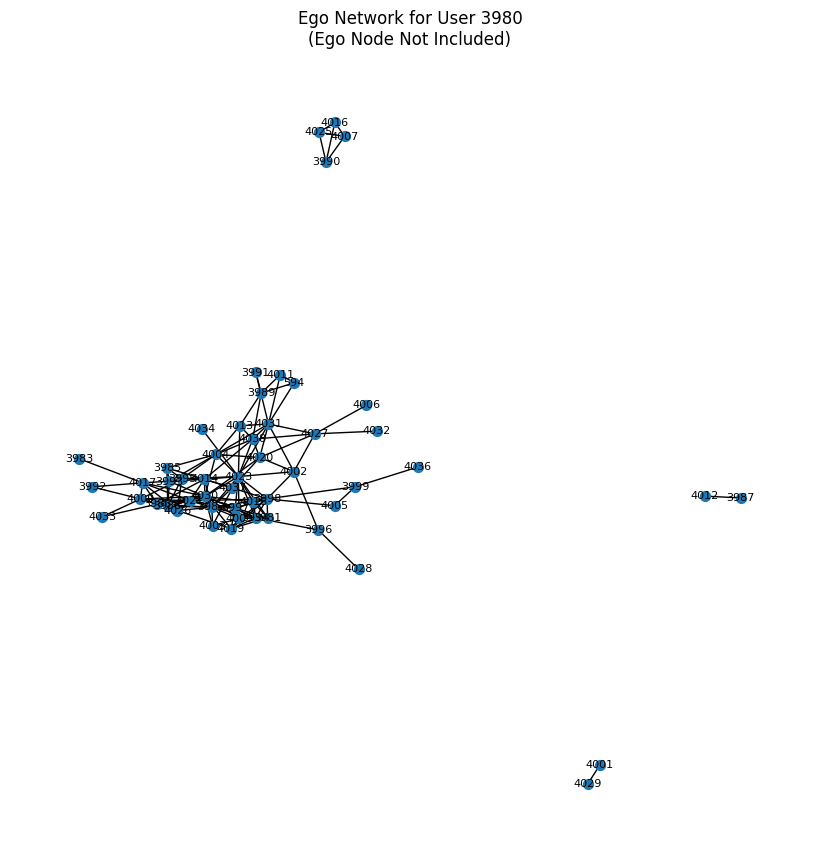

In [ ]:
selection = sorted_edge_count[0][0]
G = nx.Graph()
# Add edges to the graph
for index, row in edges_data[selection].iterrows():
    G.add_edge(row['node1'], row['node2'])
# Draw the network
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.title(f'Ego Network for User {selection}\n(Ego Node Not Included)')
plt.show()

In [ ]:
G_info = {"nodes": G.number_of_nodes(),
          "edges": G.size(),
          "diameter": "NA; Graph Not Connected"}
print(G_info)

{'nodes': 52, 'edges': 146, 'diameter': 'NA; Graph Not Connected'}


The graph has 52 nodes, 146 edges, and no diameter (since the graph is not connected).

Note that node 3980, the ego itself, was intentionally not included in this representation of the network by the data compilers, but in reality the ego node does share an edge with each node in their network. So we build an alternate version of the graph, in which the ego node and all of its edges are included, and we visualize that below. Since the graph is only connected when the ego node is included, we prefer this representation of the network.

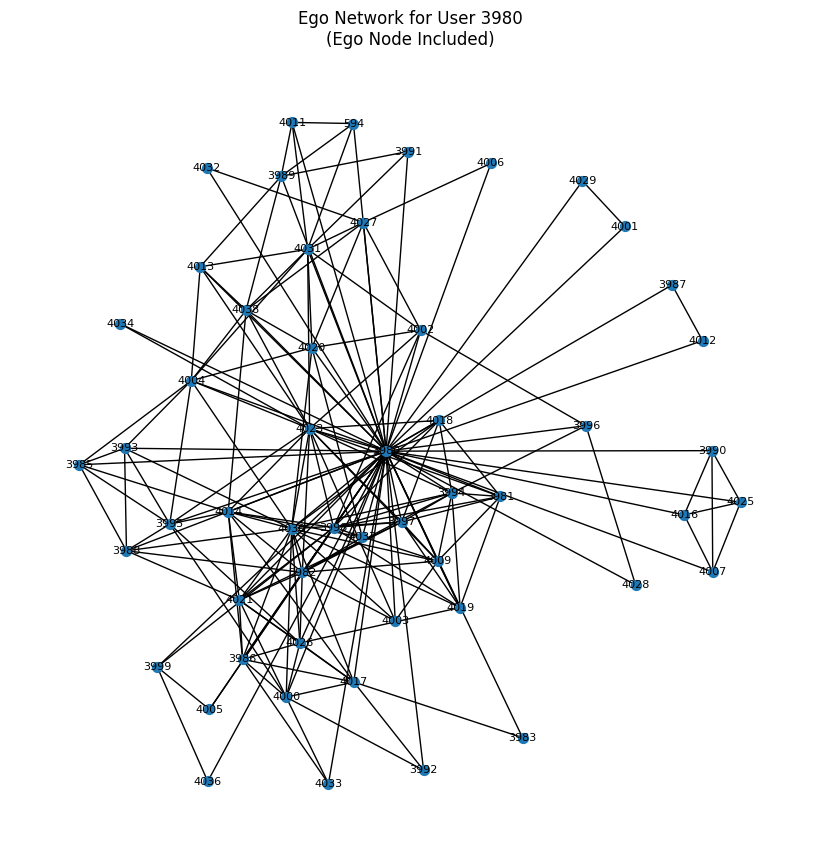

In [ ]:
H = G.copy()
for n in list(H.nodes):
    H.add_edge(int(selection), n)
plt.figure(figsize=(8, 8))
nx.draw(H, with_labels=True, node_size=50, font_size=8)
plt.title(f'Ego Network for User {selection}\n(Ego Node Included)')
plt.show()

In [ ]:
H_info = {"nodes": H.number_of_nodes(),
          "edges": H.size(),
          "diameter": nx.diameter(H)}
print(H_info)

{'nodes': 53, 'edges': 198, 'diameter': 2}


The new graph has 53 nodes, 198 edges, and a diameter of 2 since every user can reach every other user through the ego node. Now we can look at a summary of what we know about these Facebook users.

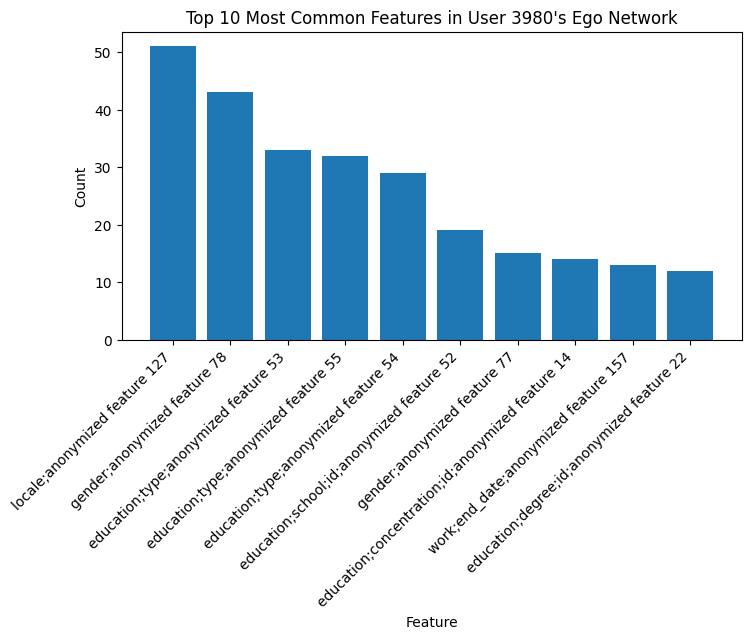

In [ ]:
feature_counts = {}
feat_df = feat_data[selection]
# Add the ego node's features since those were recorded separately
fn = base + "3980.egofeat"
new_row = pd.read_csv(fn, sep=' ', header=None, names = feat_df.columns)
new_row.rename(index = {0: 3980}, inplace = True)
feat_df = pd.concat([feat_df, new_row])
# Sum up the occurrences of each feature
for feature in feat_df.columns:
    feature_counts[feature] = feat_df[feature].sum()
# Convert the feature_counts dictionary to a list of (feature, count) tuples and sort them by count in descending order
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
# Select the top N features to visualize
top_n = 10
top_features, top_counts = zip(*sorted_features[:top_n])
# Plotting
plt.figure(figsize=(8, 4))
plt.bar(top_features, top_counts)
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.title(f"Top 10 Most Common Features in User {selection}'s Ego Network")
plt.show()

We see that many users in user 3980's ego network have listed one of two genders (anonymized feature 77 and anonymized feature 78). Since we don't know which gender identities the anonymized features correspond to by design, we rename anonymized feature 77 as Gender A and anonymized feature 78 as Gender B, and we create a third level, Gender U, to indicate a user's gender is unlisted.

In [ ]:
rename = {"gender;anonymized feature 77": "Gender A",
          "gender;anonymized feature 78": "Gender B"}
feat_df.rename(columns = rename, inplace = True)
sub = feat_df.loc[:, ["Gender A", "Gender B"]]
sub["Gender U"] = abs(sub.sum(axis=1) - 1)
sub.reset_index(inplace = True)
sub.rename(columns = {"index": "Node"}, inplace = True)
melt = pd.melt(sub, id_vars = "Node", value_vars = ["Gender A", "Gender B", "Gender U"],
               var_name = "Gender", value_name = "Value")
melt = melt[melt["Value"] == 1]
melt.drop(columns = "Value", inplace = True)
melt["Color"] = "NA"
melt.loc[melt["Gender"] == "Gender A", "Color"] = "#1B9E77"
melt.loc[melt["Gender"] == "Gender B", "Color"] = "#D95F02"
melt.loc[melt["Gender"] == "Gender U", "Color"] = "#7570B3"

We now represent the graph with the gender of the nodes color-coded.

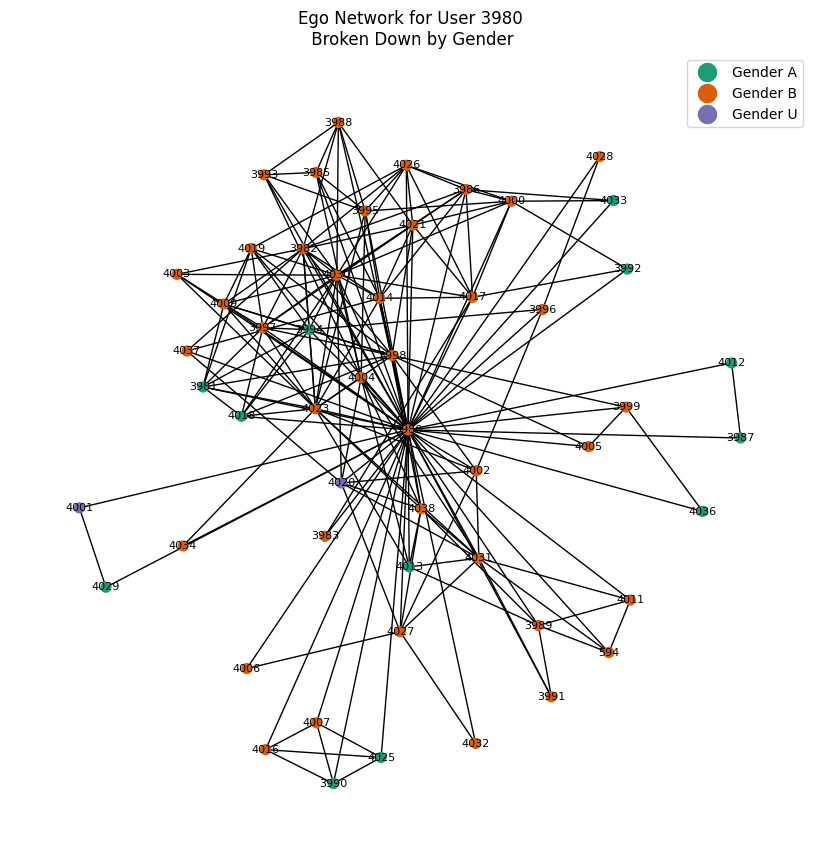

In [ ]:
gender_dict = melt.set_index("Node")["Gender"].to_dict()
color_dict = melt.set_index("Node")["Color"].to_dict()
nx.set_node_attributes(H, gender_dict, name = "Gender")
nx.set_node_attributes(H, color_dict, name = "Color")
plt.figure(figsize=(8, 8))
colors = [n[1]["Color"] for n in H.nodes(data=True)]
nx.draw(H, with_labels=True, node_color = colors, node_size=50, font_size = 8)
legend_elements = [Line2D([0], [0], marker='o', color='w', label="Gender A",
                          markerfacecolor="#1B9E77", markersize=15),
                   Line2D([0], [0], marker='o', color='w', label="Gender B",
                          markerfacecolor="#D95F02", markersize=15),
                   Line2D([0], [0], marker='o', color='w', label="Gender U",
                          markerfacecolor="#7570B3", markersize=15)]
plt.legend(handles=legend_elements, loc='upper right')
plt.title(f'Ego Network for User {selection}\n Broken Down by Gender')
plt.show()

Next, we calculate the degree and eignevector centrality measures for all the nodes in this graph, which allows us to identify the five most influential users, as well as the five least influential users. We consider both centrality metrics in order to see if some users are more influential according to one measure than the other.

First, we look at influence based on degree centrality.

In [ ]:
# Calculate Degree and Eigenvector Centrality
degree_centrality = nx.degree_centrality(H)
eigenvector_centrality = nx.eigenvector_centrality(H)
# Convert to DataFrame for easier handling
centrality_df = pd.DataFrame({
    'Node': degree_centrality.keys(),
    'Degree Centrality': degree_centrality.values(),
    'Eigenvector Centrality': eigenvector_centrality.values()
}).sort_values(by='Degree Centrality', ascending=False)  # Sorting primarily by Degree Centrality
# Add gender information to the DataFrame
centrality_df['Gender'] = centrality_df['Node'].apply(lambda x: gender_dict[x])
# Pinpoint top 5/bottom 5 by degree centrality
top_5 = centrality_df.head(5)
bottom_5 = centrality_df.tail(5)
print("Top 5 Users by Degree Centrality:\n", top_5)
print("\nBottom 5 Users by Degree Centrality:\n", bottom_5)


Top 5 Users by Degree Centrality:
     Node  Degree Centrality  Eigenvector Centrality    Gender
52  3980           1.000000                0.456803  Gender B
15  4030           0.365385                0.274344  Gender B
6   4023           0.346154                0.257229  Gender B
17  3982           0.269231                0.226584  Gender B
12  3998           0.269231                0.209681  Gender B

Bottom 5 Users by Degree Centrality:
     Node  Degree Centrality  Eigenvector Centrality    Gender
45  4036           0.038462                0.042674  Gender A
48  4028           0.038462                0.042864  Gender B
49  4012           0.038462                0.040846  Gender A
50  3987           0.038462                0.040846  Gender A
51  4006           0.038462                0.044395  Gender B


Next we look at influence based on eigenvector centrality.

In [ ]:
# Pinpoint top 5/bottom 5 by eigenvector centrality
centrality_df.sort_values(by = "Eigenvector Centrality", ascending = False, inplace = True)
top_5 = centrality_df.head(5)
bottom_5 = centrality_df.tail(5)
print("Top 5 Users by Eigenvector Centrality:\n", top_5)
print("\nBottom 5 Users by Eigenvector Centrality:\n", bottom_5)

Top 5 Users by Eigenvector Centrality:
     Node  Degree Centrality  Eigenvector Centrality    Gender
52  3980           1.000000                0.456803  Gender B
15  4030           0.365385                0.274344  Gender B
6   4023           0.346154                0.257229  Gender B
17  3982           0.269231                0.226584  Gender B
12  3998           0.269231                0.209681  Gender B

Bottom 5 Users by Eigenvector Centrality:
     Node  Degree Centrality  Eigenvector Centrality    Gender
45  4036           0.038462                0.042674  Gender A
40  4001           0.038462                0.040846  Gender U
39  4029           0.038462                0.040846  Gender A
49  4012           0.038462                0.040846  Gender A
50  3987           0.038462                0.040846  Gender A


The five most influential users in this graph are the same whether we look at degree centrality or eigenvector centrality, and they all share the same gender: Gender B. There are some differences among the five least influential users, however. By degree centrality, there are a couple Gender B users with very little influence. By eigenvector centrality, however, no Gender B users make the bottom five.

In [ ]:
gender_comparison = centrality_df.groupby('Gender').mean()[['Degree Centrality', 'Eigenvector Centrality']]
print("\nCentrality Measures by Gender:\n", gender_comparison)


Centrality Measures by Gender:
           Degree Centrality  Eigenvector Centrality
Gender                                             
Gender A           0.086538                0.080005
Gender B           0.163708                0.125794
Gender U           0.096154                0.078150


Gender B has the highest means in both centrality measures, indicating that Gender B users might be more influential within this network. Not only do they have more connections (resulting in higher degree centrality), they are also connected to more well-connected users (resulting in higher eigenvector centrality). It's interesting that the ego node is also Gender B, and sharing the gender of the ego node is potentially important for having influence in the network.

We confirm whether the differences in the centrality measure means for Gender A and Gender B are statistically significant using two-sample t-tests.

In [ ]:
print("Degree Centrality Two-Sample T-Test:")
gen_a_dc = centrality_df.loc[centrality_df["Gender"] == "Gender A", "Degree Centrality"]
gen_b_dc = centrality_df.loc[centrality_df["Gender"] == "Gender B", "Degree Centrality"]
print(f"Variance Ratio: {np.var(gen_b_dc) / np.var(gen_a_dc)} | Considered Unequal Variance")
stats.ttest_ind(a=gen_a_dc, b=gen_b_dc, equal_var=False)

Degree Centrality Two-Sample T-Test:
Variance Ratio: 8.74026001569426 | Considered Unequal Variance


TtestResult(statistic=-2.544504618307257, pvalue=0.014211591756729494, df=48.04613818367403)

In [ ]:
print("Eigenvector Centrality Two-Sample T-Test:")
gen_a_ec = centrality_df.loc[centrality_df["Gender"] == "Gender A", "Eigenvector Centrality"]
gen_b_ec = centrality_df.loc[centrality_df["Gender"] == "Gender B", "Eigenvector Centrality"]
print(f"Variance Ratio: {np.var(gen_b_ec) / np.var(gen_a_ec)} | Considered Equal Variance")
stats.ttest_ind(a=gen_a_ec, b=gen_b_ec, equal_var=True)

Eigenvector Centrality Two-Sample T-Test:
Variance Ratio: 2.7601313950228374 | Considered Equal Variance


TtestResult(statistic=-1.79977543595836, pvalue=0.07805452360900789, df=49.0)

## Conclusion

There is a statistically significant difference between the degree centrality means for Gender A and Gender B; however, the difference between their eigenvector centrality means is not statistically significant. So while Gender B has more connections than Gender A in this network, both genders have similar levels of well-connected nodes.